# ARF bias considering positional dependency

In [1]:
import numpy as np
import pandas as pd
from Bio.Seq import reverse_complement
from collections import Counter
from itertools import product
from tqdm.notebook import tqdm
from pyscripts.datasets import DatasetLoader, Metadata
from pyscripts.genomeutil import is_regular, sliding, bac_translate
metadata = Metadata()
dloader = DatasetLoader()

In [2]:
fw1 = lambda bc: bac_translate(bc[1:4])
fw2 = lambda bc: bac_translate(bc[2:5])
rc1 = lambda bc: bac_translate(reverse_complement(bc[1:4]))
rc2 = lambda bc: bac_translate(reverse_complement(bc[2:5]))

In [3]:
codon_idx = [*map(''.join, product('ACGT', repeat=3))]
bicodon_idx = [*map(''.join, product('ACGT', repeat=6))]

In [4]:
def count_freqs_bin(gcf, nbins=10):
    rec = max(dloader.load_genome(gcf), key=len)
    genome_seq = str(rec.seq)
    cds_seqs = [
        cds.location.extract(genome_seq)[3:-3] # drop start/stop codons
        for cds in filter(lambda feat: feat.type=='CDS', rec.features)
        if is_regular(cds, rec)
    ]
    len_distr = pd.Series([len(seq) // 3 for seq in cds_seqs])
    cum_residues = len_distr.value_counts().sort_index(ascending=False).cumsum().reindex(range(1, len_distr.max()+1), method='pad').cumsum()    
    total = len_distr.sum()
    thresh = [
        (cum_residues >= total * b).idxmax() * 3
        for b in np.linspace(0, 1, nbins+1)[1:]
    ]
    binned_codons = pd.DataFrame({
        f'#{bin_id}':
        pd.Series(
            Counter(cd for seq in cds_seqs for cd in sliding(seq[lb:ub], 3, 3)),
            index=codon_idx, dtype=pd.Int32Dtype()
        )
        for bin_id, (lb, ub) in enumerate(zip([0]+thresh, thresh), start=1)
    }, index=codon_idx, dtype=pd.Int32Dtype())
    
    binned_bicodons = pd.DataFrame({
        f'#{bin_id}':
        pd.Series(
            Counter(cd for seq in cds_seqs for cd in sliding(seq[lb:ub], 6, 3)),
            index=bicodon_idx, dtype=pd.Int32Dtype()
        )
        for bin_id, (lb, ub) in enumerate(zip([0]+thresh, thresh), start=1)
    }, index=bicodon_idx, dtype=pd.Int32Dtype())
    
    return gcf, binned_codons, binned_bicodons


In [5]:
def calc_Z_stop(obs_codons, obs_bicodons):
    codon_usage = (obs_codons / obs_codons.groupby(bac_translate).transform('sum')).fillna(0)
    exp_bicodons = obs_bicodons.groupby(bac_translate).transform('sum') \
                    * obs_bicodons.index.to_series().str[:3].apply(lambda c: codon_usage.loc[c]) \
                    * obs_bicodons.index.to_series().str[3:].apply(lambda c: codon_usage.loc[c]) 
    Z_stop = pd.DataFrame()
    for frame, arf in zip(['+1','+2','-1','-2'], [fw1, fw2, rc1, rc2]):
        exp_aa = exp_bicodons.groupby(arf).sum()
        obs_aa = obs_bicodons.groupby(arf).sum()
        N = exp_aa.sum()
        obs_stop, exp_stop = obs_aa.loc['*'], exp_aa.loc['*']
    
        Z_stop[frame] = (obs_stop - exp_stop) / np.sqrt((N * exp_stop - exp_stop ** 2) / (N - 1))
    
    return Z_stop


In [6]:
from multiprocessing import Pool
def work(gcf):
    gcf, binned_codons, binned_bicodons = count_freqs_bin(gcf, nbins=10)
    Z_stop = calc_Z_stop(binned_codons, binned_bicodons)
    return gcf, Z_stop
    
Z_stop_summary = pd.DataFrame(
    index=[f'#{bin_id}' for bin_id in range(1, 11)], 
    columns=pd.MultiIndex.from_product([metadata.acc['refseq'], ['+1','+2','-1','-2']])
)
with Pool(100) as pool:
    for gcf, Z_stop in tqdm(pool.imap_unordered(work, metadata.acc['refseq']), total=len(metadata.acc)):
        Z_stop_summary[gcf] = Z_stop

Z_stop_summary = Z_stop_summary.swaplevel(axis=1).sort_index(axis=1).rename_axis(index='bin')

  0%|          | 0/2624 [00:00<?, ?it/s]

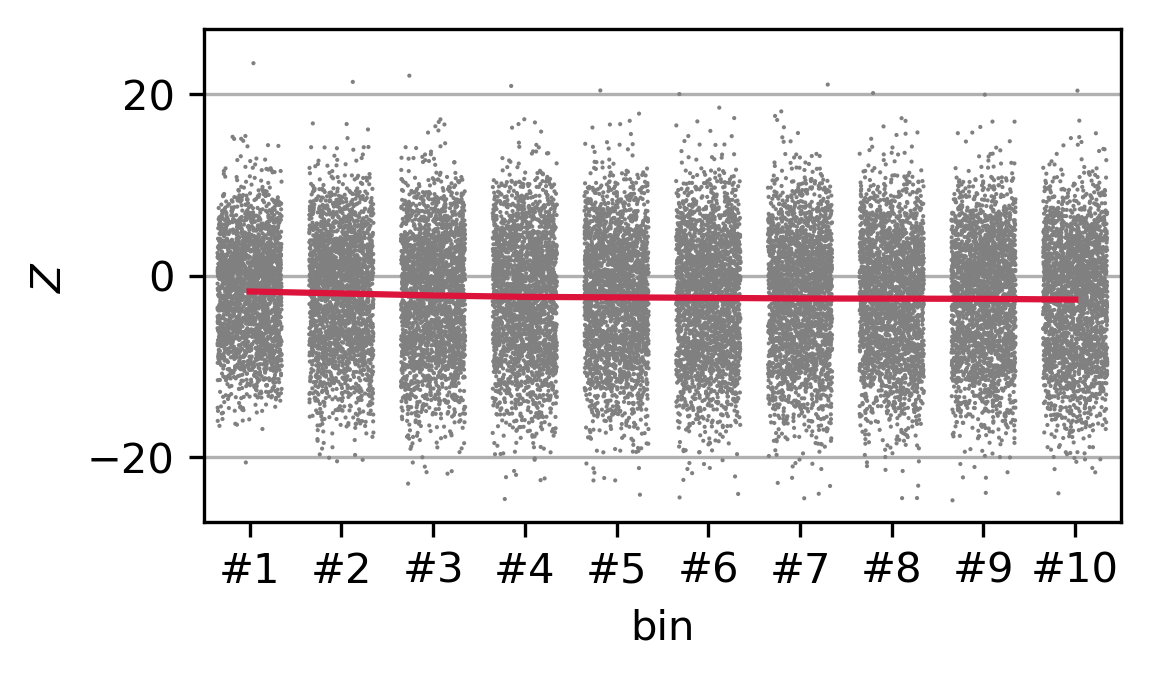

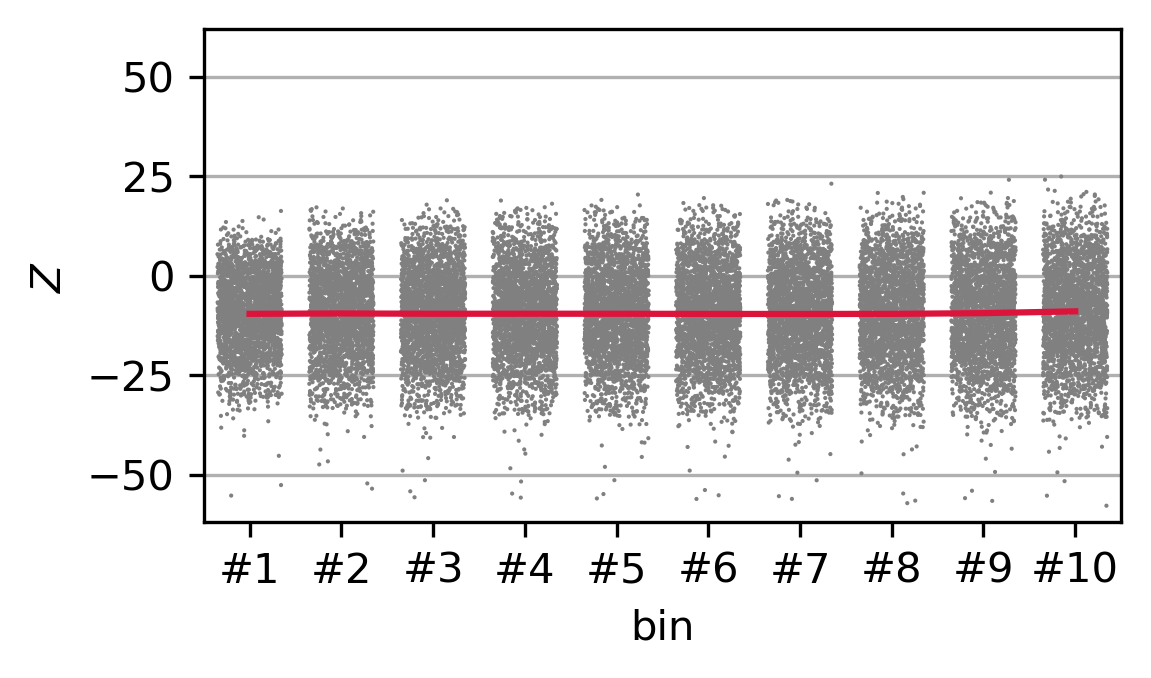

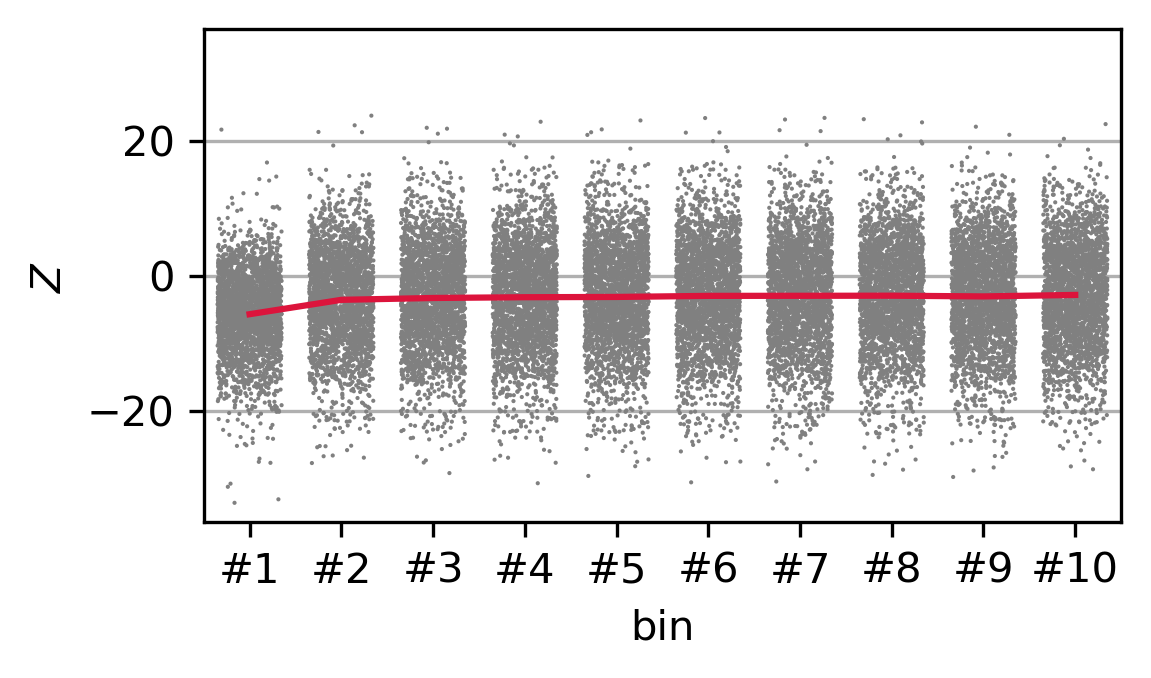

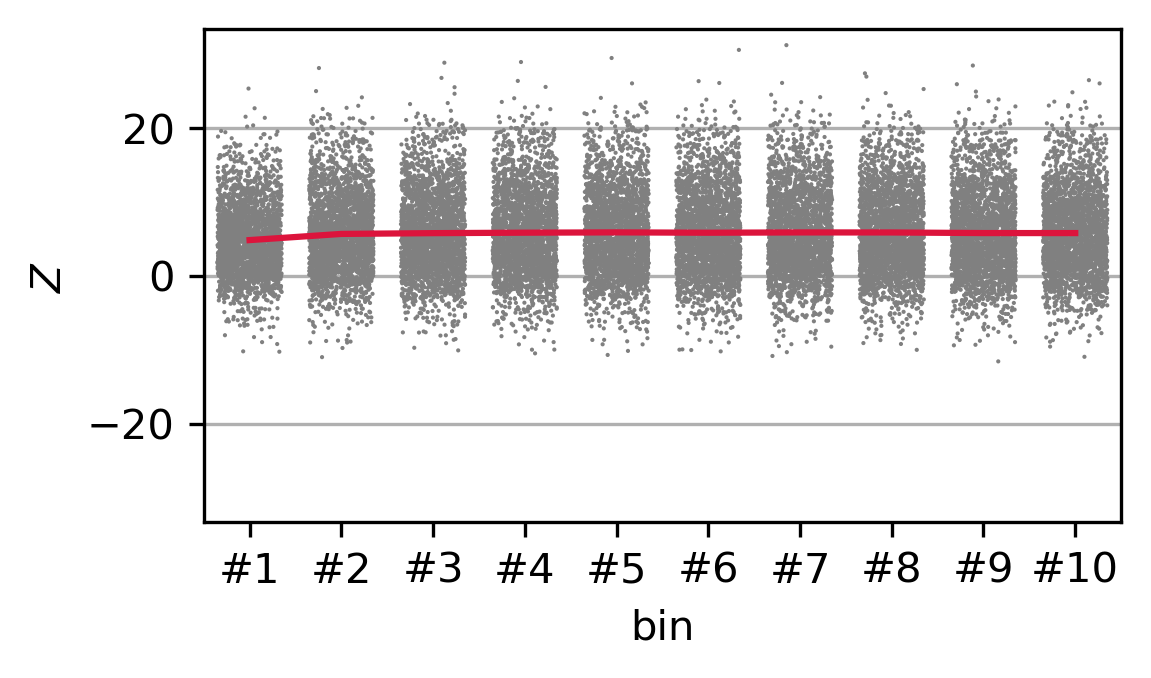

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

mm = 1 / 25.4

for frame in ['+1','+2','-1','-2']:
    fig, ax = plt.subplots(figsize=(100*mm, 60*mm), dpi=300)

    sns.lineplot(
        x='bin', y='mean', zorder=3, color='crimson',
        data=Z_stop_summary[frame].mean(axis=1).rename('mean').reset_index()
    )
    sns.stripplot(
        x='bin', y='$Z$', ax=ax, jitter=0.35, s=1, color='gray',
        data=Z_stop_summary[frame].unstack().rename('$Z$').reset_index()
    )    
    ax.yaxis.grid()
    ymax = max(map(abs, ax.get_ylim()))
    ax.set_ylim(-ymax, ymax)

    fig.tight_layout()

- Figures will be revised